# Wildfire Area Prediction Starting Kit

_Authors: Corentin Ambroise, Bastien Galmiche, Luis Montero, Margaux Zaffran_

## Table of contents

1. [Introduction](#introduction)
    1. [Context](#context)
    2. [Objective](#problematic)
    3. [Benefits](#KPI)
    4. [Dependancies](#librairies)
2. [Data](#data)
    1. [Main dataset](#fires)
    2. [Weather datasets](#weather)
    3. [Forest dataset](#forest)
    4. [INSEE dataset](#insee)
3. [Loss](#loss)
4. [Exploratory data analysis](#explo)
    1. [Fires](#fires_explo)
    2. [Weather and fires](#weather_explo)
    3. [Forest and fires](#forest_explo)
    4. [INSEE and fires](#insee_explo)
5. [Model](#model)
    1. [Feature extractor](#features)
    2. [Regressor](#regressor)
    3. [Baseline model](#baseline)
    4. [Naive merges](#merges)
6. [RAMP submission](#ramp)

## Introduction <a name="introduction"></a>

### Context <a name="Context"></a>

### Objective <a name="objective"></a>

### Benefits <a name="benefits"></a>

### Dependancies <a name="librairies"></a>

## Data <a name="data"></a>

### Main dataset <a name="fires"></a>

### Weather datasets <a name="weather"></a>

### Forest dataset <a name="forest"></a>

### INSEE dataset <a name="insee"></a>

## Loss <a name="loss"></a>

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [106]:
alpha = 0.7
p = 2
y = [0.0001,12,20,55,150,400,1100,2980,8100,22000,60000,160000,440000]
ypred = np.arange(0.0001,500000,10)

In [126]:
def quadquadlog(alpha,p,y,ypred):
    return 2*(alpha+(1-2*alpha)*(1*((np.log(y)-np.log(ypred)) < 0)))*((np.log(y)-np.log(ypred))**p)

/Users/margauxzaffran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if __name__ == '__main__':


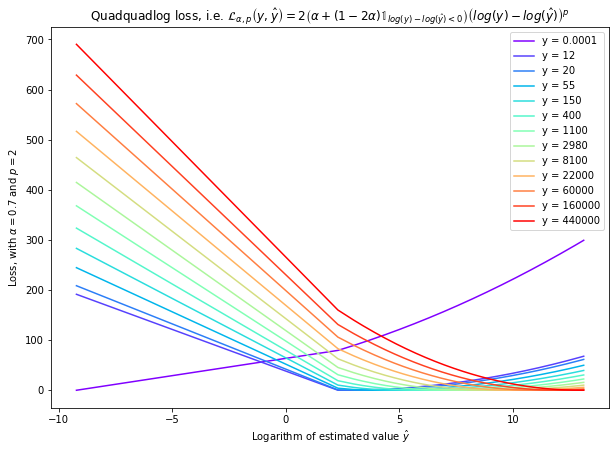

In [130]:
plt.figure(figsize=(10,7))
colors = cm.rainbow(np.linspace(0, 1, len(y)))
for elem, c in zip(y, colors):
    plt.plot(np.log(ypred), quadquadlog(alpha,p,elem,ypred),color=c,label='y = '+str(elem))
plt.legend()
plt.xlabel(r'Logarithm of estimated value $\hat{y}$')
plt.ylabel(r'Loss, with $\alpha = 0.7$ and $p = 2$')
plt.title(r'Quadquadlog loss, i.e. $\mathcal{L}_{\alpha,p}\left(y,\hat{y}\right) = 2\left( \alpha + (1-2\alpha)\mathbb{1}_{log(y)-log(\hat{y}) < 0} \right)\left(log(y) - log(\hat{y}) \right)^{p}$')
plt.savefig('Quadquadlog_loss_0.7_2.png')

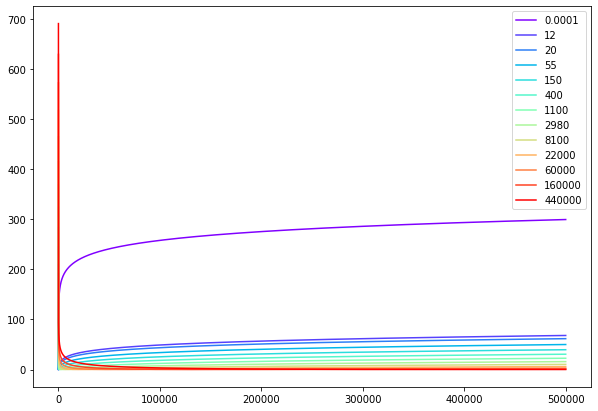

In [128]:
plt.figure(figsize=(10,7))
colors = cm.rainbow(np.linspace(0, 1, len(y)))
for elem, c in zip(y, colors):
    plt.plot(ypred, quadquadlog(alpha,p,elem,ypred),color=c,label=elem)
plt.legend()

## Exploratory data analysis  <a name="explo"></a>

### Fires  <a name="fires_explo"></a>

### Weather and fires <a name="weather_explo"></a>

### Forest and fires <a name="forest_explo"></a>

### INSEE and fires <a name="insee_explo"></a>

## Model  <a name="model"></a>

### Feature extractor  <a name="features"></a>

### Regressor  <a name="regressor"></a>

### Baseline model  <a name="baseline"></a>

### Naive merges  <a name="merges"></a>

## RAMP submission <a name="ramp"></a>